In [1]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Veri artırma için ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim ve doğrulama veri yükleyicileri
train_generator = train_datagen.flow_from_directory(
    'Organized_Damage_Level/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    'Organized_Damage_Level/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ResNet50 tabanlı model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modelin sonuna yeni katmanlar ekleyin
x = base_model.output
x = BatchNormalization(axis=-1)(x)
x = GlobalAveragePooling2D()(x)  # Ortalama havuzlama katmanı
x = Dense(1024, activation='relu')(x)  # Yeni yoğun katman
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Sınıf sayısı kadar çıkış
model = Model(inputs=base_model.input, outputs=predictions)

# Base model katmanlarını dondurma
for layer in base_model.layers:
    layer.trainable = False

# Modeli derleme
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



Found 3427 images belonging to 4 classes.
Found 1096 images belonging to 4 classes.


In [5]:
# Modeli eğitme
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
)



Epoch 1/40
108/108 [==============================] - 25s 229ms/step - loss: 1.0431 - accuracy: 0.5395 - val_loss: 1.0225 - val_accuracy: 0.5210
Epoch 2/40
108/108 [==============================] - 25s 229ms/step - loss: 1.0461 - accuracy: 0.5287 - val_loss: 1.0357 - val_accuracy: 0.5265
Epoch 3/40
108/108 [==============================] - 23s 211ms/step - loss: 1.0415 - accuracy: 0.5413 - val_loss: 1.0351 - val_accuracy: 0.5328
Epoch 4/40
108/108 [==============================] - 23s 211ms/step - loss: 1.0426 - accuracy: 0.5357 - val_loss: 1.0290 - val_accuracy: 0.5255
Epoch 5/40
108/108 [==============================] - 23s 213ms/step - loss: 1.0362 - accuracy: 0.5241 - val_loss: 1.0447 - val_accuracy: 0.5228
Epoch 6/40
108/108 [==============================] - 24s 224ms/step - loss: 1.0520 - accuracy: 0.5264 - val_loss: 1.0268 - val_accuracy: 0.5365
Epoch 7/40
108/108 [==============================] - 23s 215ms/step - loss: 1.0353 - accuracy: 0.5392 - val_loss: 1.0154 - val_ac

In [ ]:
# Modeli kaydetme
model.save('damage_classification_resnet50.h5')


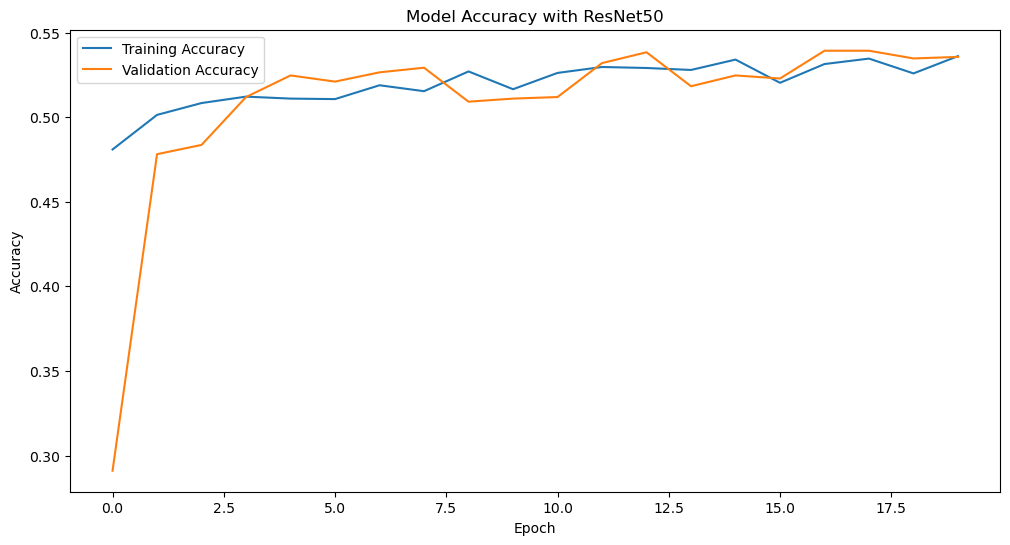

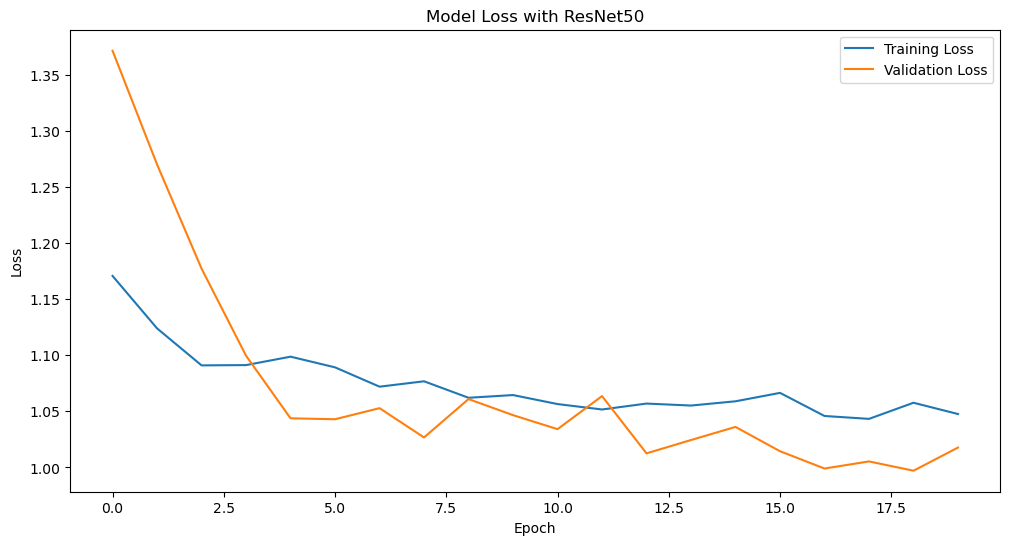

In [4]:
# Eğitim doğruluğu ve doğrulama doğruluğunu çizme
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Eğitim kaybı ve doğrulama kaybını çizme
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
